# Feature Selection

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from config import *

In [2]:
k=20

In [108]:
features_raw = pd.read_parquet(FEATURES_DIR / "features.pq")
features_raw.shape

(171, 223)

In [70]:
y = pd.DataFrame(features_raw["y"], columns=["y"])
X = features_raw.drop(["participant_id", "y"], axis=1)
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns)

In [72]:
X.shape

(171, 221)

## Criteria 1: Minimum accepted variance of features

$$
v_f < mav = 0.1
$$

In [56]:
from sklearn.feature_selection import VarianceThreshold

In [76]:
selector = VarianceThreshold(threshold=0.1)
min_variance_features = selector.fit_transform(X_scaled)

# Get the selected feature names
min_variance_features_names = X_scaled.columns[selector.get_support()]

# Create data_frame with min variance features
X1 = pd.DataFrame(min_variance_features, columns=min_variance_features_names)

print(f"Kept {X1.shape[1]} features out of {X_scaled.shape[1]}")

Kept 205 features out of 221


In [77]:
X1.shape

(171, 205)

## Criteria 2: Maximum accepted correlation of features

$$
r_{f_{x}f_{y}} < mac = 0.85
$$

In [99]:
# Calculate the correlation matrix
corr_matrix = X1.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop columns that are more than 85 % correlate
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
X2 = X1.drop(columns=to_drop)

print(f"Removed {len(to_drop)} highly correlated features: {to_drop}")

Removed 46 highly correlated features: ['ANTI_SACCADE_prop_correct_trials', 'ANTI_SACCADE_reaction_time_std', 'FITTS_LAW_mean_pupil_size_fix', 'FITTS_LAW_avg_fixations_pr_second', 'FIXATIONS_mean_pupil_size_fix', 'FIXATIONS_total_acceleration_magnitude_left_median', 'FIXATIONS_total_acceleration_magnitude_right_median', 'FIXATIONS_distance_to_fixpoint_median', 'FIXATIONS_distance_to_fixpoint_y_median', 'FIXATIONS_distance_to_fixpoint_y_std', 'KING_DEVICK_mean_pupil_size_fix', 'KING_DEVICK_median_saccades_pr_second', 'EVIL_BASTARD_mean_pupil_size_fix', 'EVIL_BASTARD_std_fixations_pr_second', 'EVIL_BASTARD_total_acceleration_magnitude_left_median', 'EVIL_BASTARD_total_acceleration_magnitude_right_median', 'EVIL_BASTARD_distance_to_fixpoint_median', 'EVIL_BASTARD_distance_to_fixpoint_x_mean', 'EVIL_BASTARD_distance_to_fixpoint_x_max', 'EVIL_BASTARD_distance_to_fixpoint_x_median', 'EVIL_BASTARD_distance_to_fixpoint_x_std', 'EVIL_BASTARD_distance_to_fixpoint_y_median', 'REACTION_mean_pupil_

In [81]:
X2.shape

(171, 159)

## Criteria 3: Minimum acceptable individual correlation

$$
r_{f,Patient} > maic
$$

In [106]:
columns_to_drop = []
for col in X2.columns:
    corr = y.corrwith(X2[col]).abs().iloc[0]
    if corr < 0.1:
        columns_to_drop.append(col)

X3 = X2.drop(columns=columns_to_drop)

In [107]:
X3.shape

(171, 59)

## 2-sample t-test

In [9]:
from scipy import stats

In [ ]:
control = X2.merge(y, left_index=True, right_index=True).query('y==0')
patient = X2.merge(y, left_index=True, right_index=True).query('y==1')
sig_features = []

for feature in X3.columns:
    if feature in ["participant_id", 'y']:
        continue
    t_stat, p_value = stats.ttest_ind(control[control[feature].notna()][feature], patient[patient[feature].notna()][feature])
    alpha = 0.05
    if p_value < alpha:
        sig_features.append([feature,p_value])

In [119]:
len(sig_features)

28

In [12]:
sig_features_df = pd.DataFrame(sig_features, columns = ['Feature', 'P_value']) 

In [13]:
top_20_features_significance = list(sig_features_df.sort_values("P_value").head(20)["Feature"])

In [14]:
top_20_features_significance

['REACTION_reaction_time_avg',
 'KING_DEVICK_avg_time_elapsed_pr_trial',
 'EVIL_BASTARD_distance_to_fixpoint_max',
 'REACTION_reaction_time_std',
 'KING_DEVICK_total_acceleration_magnitude_right_median',
 'ANTI_SACCADE_total_acceleration_magnitude_right_median',
 'FITTS_LAW_total_acceleration_magnitude_right_median',
 'KING_DEVICK_total_acceleration_magnitude_right_mean',
 'FITTS_LAW_mean_duration_sacc',
 'FITTS_LAW_mean_duration_fix',
 'ANTI_SACCADE_total_acceleration_magnitude_right_max',
 'FIXATIONS_total_acceleration_magnitude_right_mean',
 'EVIL_BASTARD_mean_duration_sacc',
 'EVIL_BASTARD_distance_to_fixpoint_y_max',
 'FITTS_LAW_mean_amplitude_sacc',
 'SHAPES_total_acceleration_magnitude_right_mean',
 'SMOOTH_PURSUITS_distance_to_fixpoint_y_max',
 'SMOOTH_PURSUITS_mean_peak_velocity_sacc',
 'SMOOTH_PURSUITS_distance_to_fixpoint_max',
 'FITTS_LAW_total_acceleration_magnitude_right_mean']

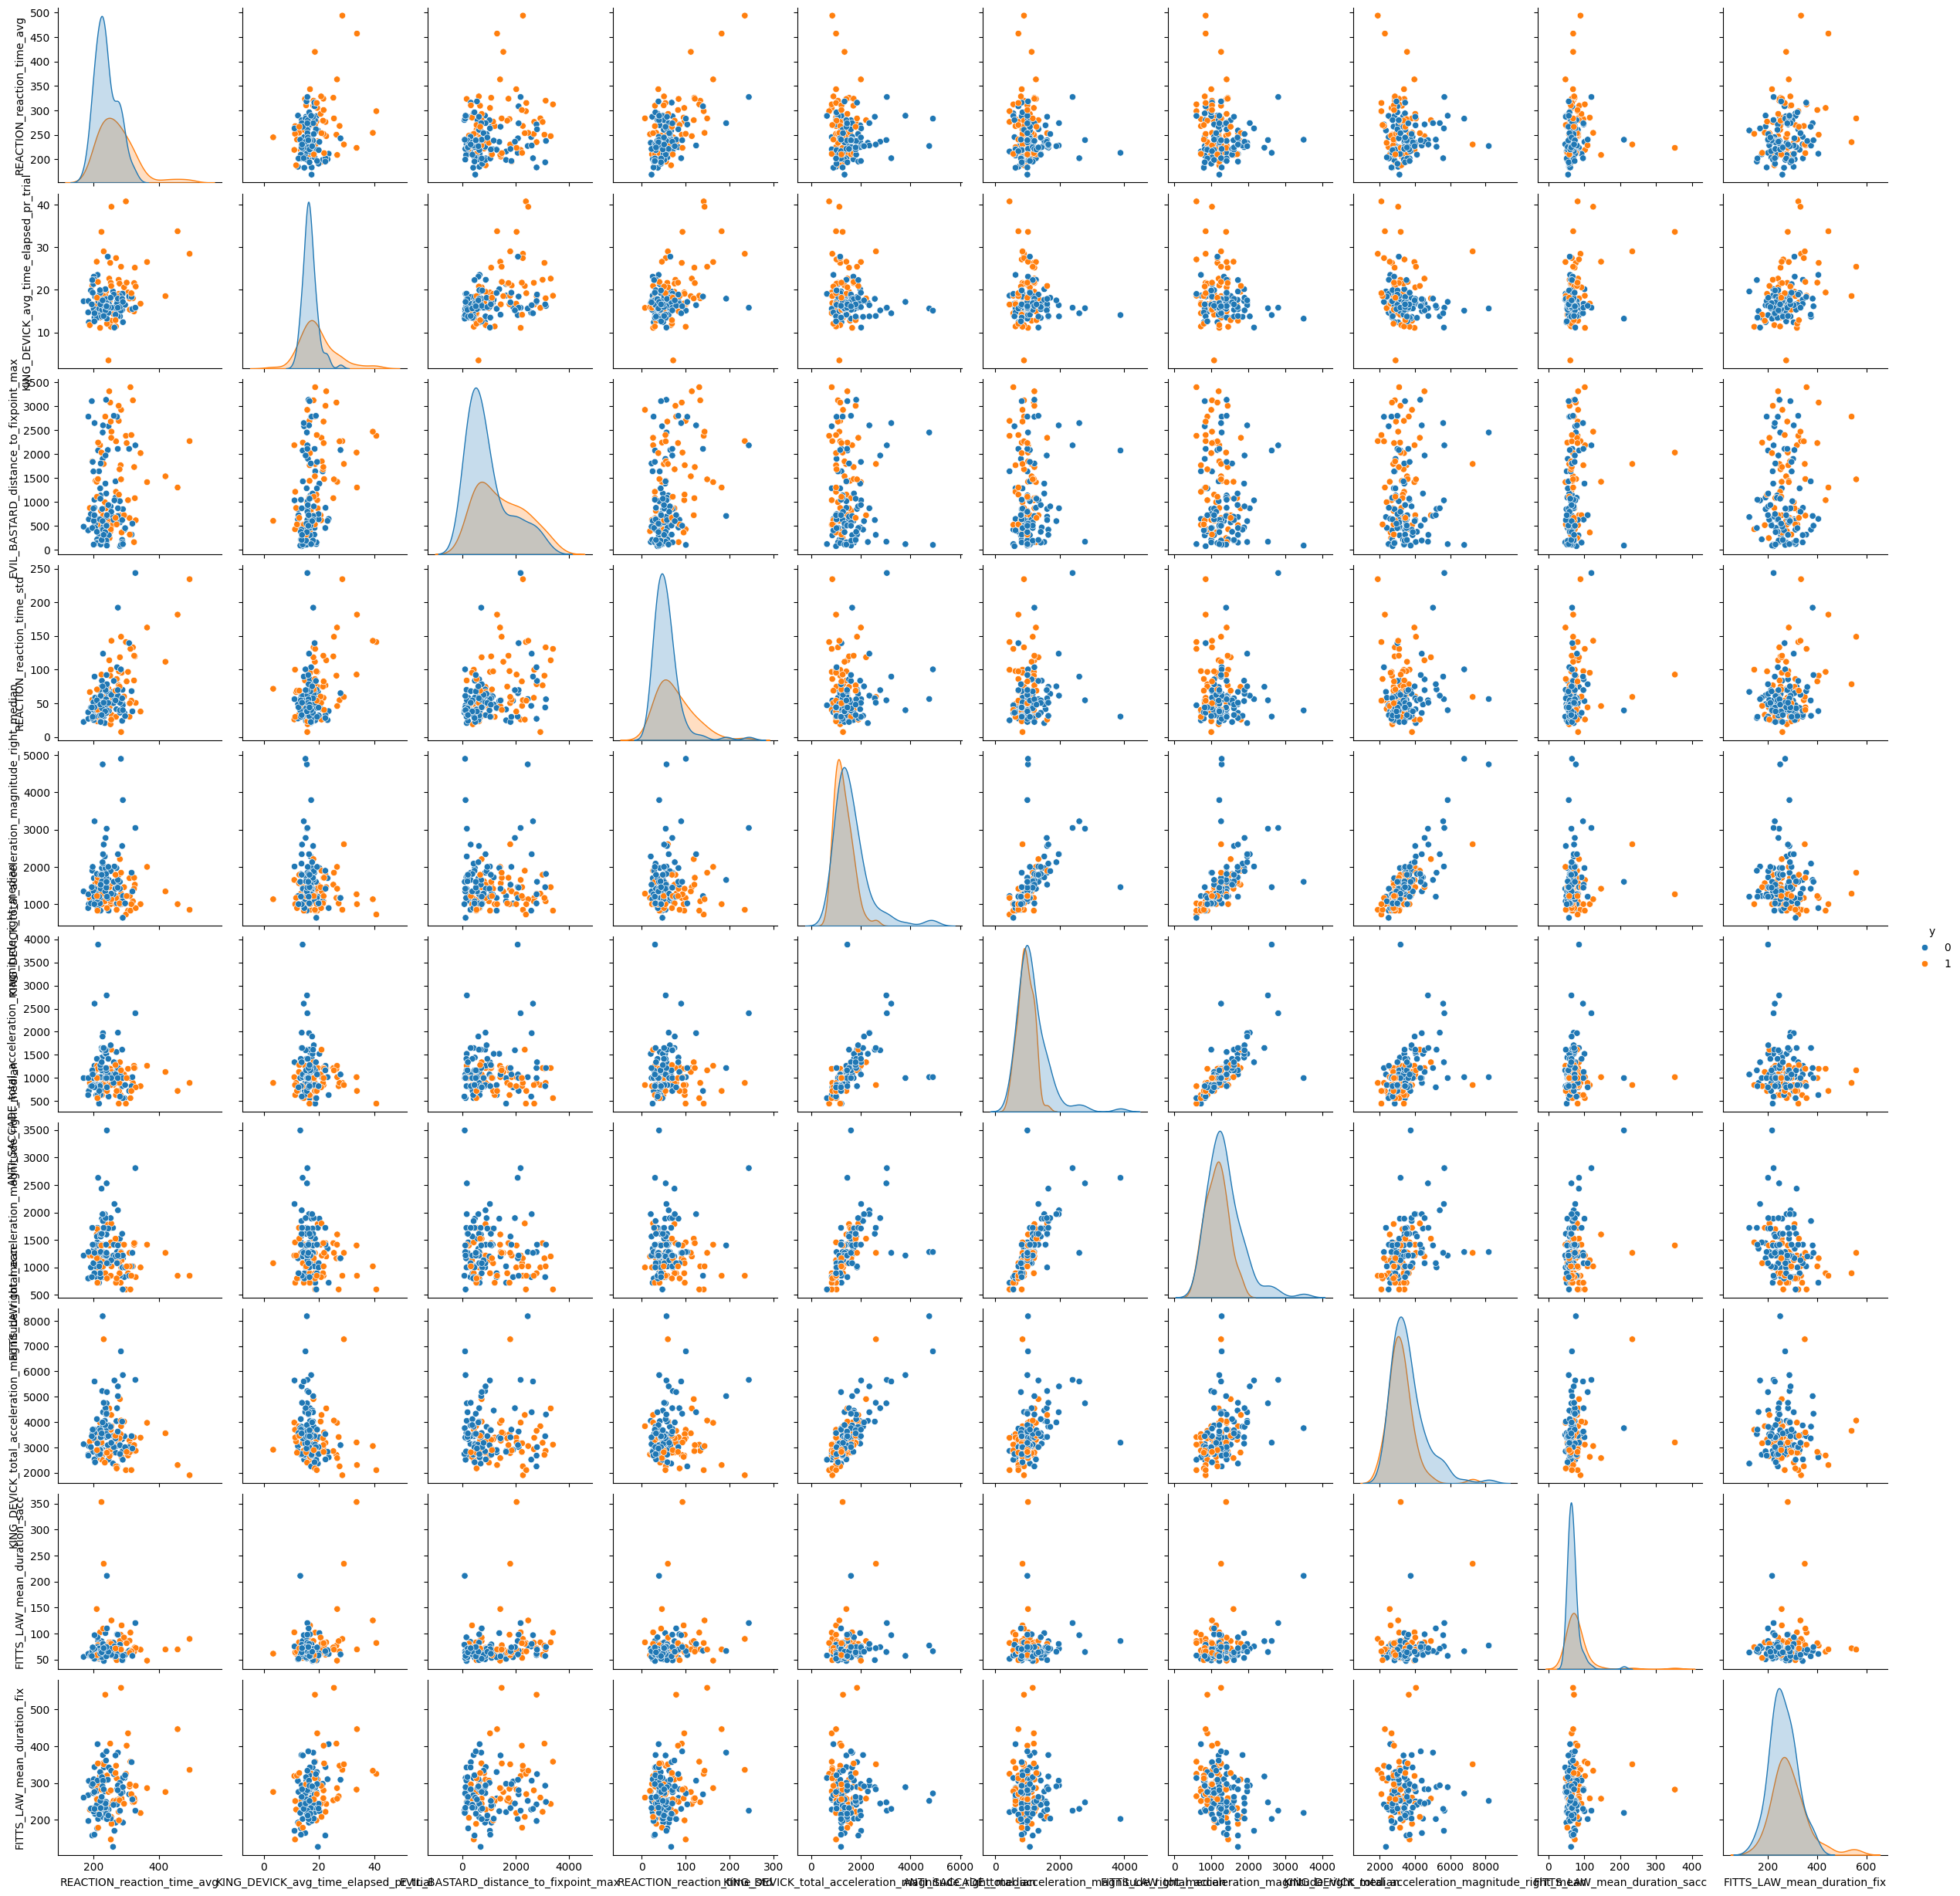

In [15]:
top_10_features_significance = list(sig_features_df.sort_values("P_value").head(10)["Feature"])
sns.pairplot(features[top_10_features_significance + ['y']], hue='y')

## PCA

In [16]:
from sklearn.decomposition import PCA

In [17]:
f = features[~np.isnan(features).any(axis=1)]

y = f["y"]
X = f.drop(["participant_id", "y"], axis=1)
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns)

In [18]:
pca = PCA()

pca.fit(X_scaled)

PCA()

In [19]:
components = pd.DataFrame(pca.components_.T,columns=[f"component_{c}" for c in range(1,len(pca.components_)+1)], index=X.columns)

In [20]:
top_20_pca_features = components.sum(axis=1).abs().sort_values(ascending=False).head(20)

In [21]:
top_20_features_significance

['REACTION_reaction_time_avg',
 'KING_DEVICK_avg_time_elapsed_pr_trial',
 'EVIL_BASTARD_distance_to_fixpoint_max',
 'REACTION_reaction_time_std',
 'KING_DEVICK_total_acceleration_magnitude_right_median',
 'ANTI_SACCADE_total_acceleration_magnitude_right_median',
 'FITTS_LAW_total_acceleration_magnitude_right_median',
 'KING_DEVICK_total_acceleration_magnitude_right_mean',
 'FITTS_LAW_mean_duration_sacc',
 'FITTS_LAW_mean_duration_fix',
 'ANTI_SACCADE_total_acceleration_magnitude_right_max',
 'FIXATIONS_total_acceleration_magnitude_right_mean',
 'EVIL_BASTARD_mean_duration_sacc',
 'EVIL_BASTARD_distance_to_fixpoint_y_max',
 'FITTS_LAW_mean_amplitude_sacc',
 'SHAPES_total_acceleration_magnitude_right_mean',
 'SMOOTH_PURSUITS_distance_to_fixpoint_y_max',
 'SMOOTH_PURSUITS_mean_peak_velocity_sacc',
 'SMOOTH_PURSUITS_distance_to_fixpoint_max',
 'FITTS_LAW_total_acceleration_magnitude_right_mean']

## Random forest

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

parameters = {'max_depth': [None,1,3,5,7,9,11], 'n_estimators': [10, 100, 1000], 'max_features': ['sqrt', 'log2', None]}

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ('clf', GridSearchCV(RandomForestClassifier(n_jobs=-1), parameters, cv=5, verbose=10))
])

print(pipe.fit(X_train, y_train).score(X_test, y_test))

In [ ]:
print(pipe["clf"].best_params_)